# Modules

In [1]:
import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import utils, datasets, transforms
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Randomseed

In [2]:
# Set random seed for reproducibility
torch.manual_seed(0)

# Hyperparameter

In [3]:
# Root directory for dataset
dataroot = "data/mnist"

# Number of workers for dataloader
workers = 10

# Batch size during training
batch_size = 100

# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 32

# Number of channels in the training images. For color images this is 3
nc = 1

# Number of classes in the training images. For mnist dataset this is 10
num_classes = 10

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 10

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Dadaset

In [4]:
train_data = datasets.MNIST(
    root=dataroot,
    train=True,
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]),
    download=True
)
test_data = datasets.MNIST(
    root=dataroot,
    train=False,
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
)
dataset = train_data+test_data
print(f'Total Size of Dataset: {len(dataset)}')

Total Size of Dataset: 70000


# Dataloader

In [5]:
dataloader = DataLoader (
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers
)

# Device

In [6]:
device = torch.device('cuda:1' if (torch.cuda.is_available() and ngpu > 0) else 'cpu')

# Training Images Visualization

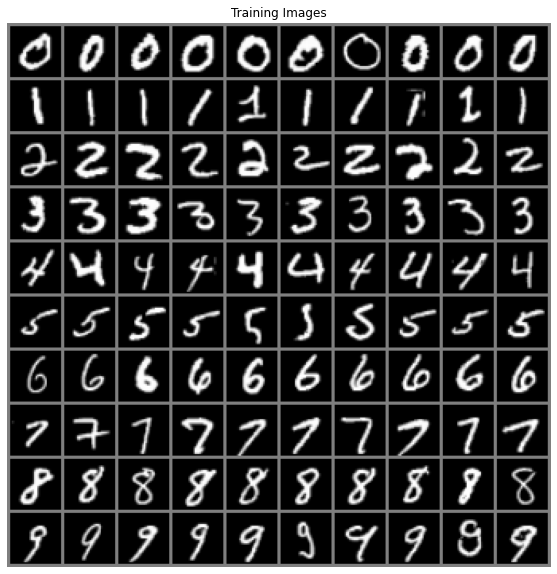

In [7]:
imgs = {}
for x, y in dataset:
    if y not in imgs:
        imgs[y] = []
    elif len(imgs[y])!=10:
        imgs[y].append(x)
    elif sum(len(imgs[key]) for key in imgs)==100:
        break
    else:
        continue
        
imgs = sorted(imgs.items(), key=lambda x:x[0])
imgs = [torch.stack(item[1], dim=0) for item in imgs]
imgs = torch.cat(imgs, dim=0)

plt.figure(figsize=(10,10))
plt.title("Training Images")
plt.axis('off')
imgs = utils.make_grid(imgs, nrow=10)
plt.imshow(imgs.permute(1, 2, 0)*0.5+0.5)

# Weight Initialization

In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Generator

![](https://img-blog.csdnimg.cn/20210322111750788.png)

In [9]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.image = nn.Sequential(
            # state size. (nz) x 1 x 1
            nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True)
            # state size. (ngf*4) x 4 x 4
        )
        self.label = nn.Sequential(
            # state size. (num_classes) x 1 x 1
            nn.ConvTranspose2d(num_classes, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True)
            # state size. (ngf*4) x 4 x 4
        )
        self.main = nn.Sequential(
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf*2, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 32 x 32
        )

    def forward(self, image, label):
        image = self.image(image)
        label = self.label(label)
        incat = torch.cat((image, label), dim=1)
        return self.main(incat)

# Instantiation of Generator

In [10]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if device.type == 'cuda' and ngpu > 1:
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.2.
netG.apply(weights_init)

Generator(
  (image): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (label): Sequential(
    (0): ConvTranspose2d(10, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (main): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)

# Discriminator

![](https://img-blog.csdnimg.cn/20210322111933227.png)

In [11]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.image = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
            # state size. (ndf) x 16 x 16
        )
        self.label = nn.Sequential(
            # input is (num_classes) x 32 x 32
            nn.Conv2d(num_classes, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
            # state size. (ndf) x 16 x 16
        )
        self.main = nn.Sequential(
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            # state size. (1) x 1 x 1
            nn.Sigmoid()
        )

    def forward(self, image, label):
        image = self.image(image)
        label = self.label(label)
        incat = torch.cat((image, label), dim=1)
        return self.main(incat)

# Instantiation of Discriminator

In [12]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if device.type == 'cuda' and ngpu > 1:
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.2.
netD.apply(weights_init)

Discriminator(
  (image): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (label): Sequential(
    (0): Conv2d(10, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (main): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (7): Sigmoid()
  )
)

#  Optimizers and Loss Functions

In [13]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label_num = 1.
fake_label_num = 0.

# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Label one-hot for G
label_1hots = torch.zeros(10,10)
for i in range(10):
    label_1hots[i,i] = 1
label_1hots = label_1hots.view(10,10,1,1).to(device)

# Label one-hot for D
label_fills = torch.zeros(10, 10, image_size, image_size)
ones = torch.ones(image_size, image_size)
for i in range(10):
    label_fills[i][i] = ones
label_fills = label_fills.to(device)

# Create batch of latent vectors and laebls that we will use to visualize the progression of the generator
fixed_noise = torch.randn(100, nz, 1, 1).to(device)
fixed_label = label_1hots[torch.arange(10).repeat(10).sort().values]

# Training

In [14]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
D_x_list = []
D_z_list = []
loss_tep = 10

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):

    beg_time = time.time()
    # For each batch in the dataloader
    for i, data in enumerate(dataloader):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        
        # Format batch
        real_image = data[0].to(device)
        b_size = real_image.size(0)

        real_label = torch.full((b_size,), real_label_num).to(device)
        fake_label = torch.full((b_size,), fake_label_num).to(device)
        
        G_label = label_1hots[data[1]]
        D_label = label_fills[data[1]]
        
        # Forward pass real batch through D
        output = netD(real_image, D_label).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, real_label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1).to(device)
        # Generate fake image batch with G
        fake = netG(noise, G_label)
        # Classify all fake batch with D
        output = netD(fake.detach(), D_label).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, fake_label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake, D_label).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, real_label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        end_time = time.time()
        run_time = round(end_time-beg_time)
        print(
            f'Epoch: [{epoch+1:0>{len(str(num_epochs))}}/{num_epochs}]',
            f'Step: [{i+1:0>{len(str(len(dataloader)))}}/{len(dataloader)}]',
            f'Loss-D: {errD.item():.4f}',
            f'Loss-G: {errG.item():.4f}',
            f'D(x): {D_x:.4f}',
            f'D(G(z)): [{D_G_z1:.4f}/{D_G_z2:.4f}]',
            f'Time: {run_time}s',
            end='\r'
        )

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Save D(X) and D(G(z)) for plotting later
        D_x_list.append(D_x)
        D_z_list.append(D_G_z2)
        
        # Save the Best Model
        if errG < loss_tep:
            torch.save(netG.state_dict(), 'model.pt')
            loss_tep = errG

    # Check how the generator is doing by saving G's output on fixed_noise and fixed_label
    with torch.no_grad():
        fake = netG(fixed_noise, fixed_label).detach().cpu()
    img_list.append(utils.make_grid(fake, nrow=10))
    
    # Next line
    print()

Starting Training Loop...
Epoch: [01/10] Step: [700/700] Loss-D: 0.7205 Loss-G: 1.8315 D(x): 0.7095 D(G(z)): [0.2365/0.2161] Time: 115s
Epoch: [02/10] Step: [700/700] Loss-D: 1.3231 Loss-G: 2.0508 D(x): 0.7644 D(G(z)): [0.5831/0.1654] Time: 116s
Epoch: [03/10] Step: [700/700] Loss-D: 1.5194 Loss-G: 2.6285 D(x): 0.8626 D(G(z)): [0.6982/0.0936] Time: 110s
Epoch: [04/10] Step: [700/700] Loss-D: 0.8259 Loss-G: 1.4162 D(x): 0.6474 D(G(z)): [0.2771/0.2739] Time: 111s
Epoch: [05/10] Step: [700/700] Loss-D: 0.4708 Loss-G: 2.3000 D(x): 0.8081 D(G(z)): [0.1971/0.1272] Time: 111s
Epoch: [06/10] Step: [700/700] Loss-D: 0.3941 Loss-G: 3.5506 D(x): 0.9606 D(G(z)): [0.2575/0.0391] Time: 118s
Epoch: [07/10] Step: [700/700] Loss-D: 0.1330 Loss-G: 3.4693 D(x): 0.9434 D(G(z)): [0.0690/0.0441] Time: 113s
Epoch: [08/10] Step: [700/700] Loss-D: 0.0821 Loss-G: 4.5200 D(x): 0.9502 D(G(z)): [0.0279/0.0196] Time: 112s
Epoch: [09/10] Step: [700/700] Loss-D: 0.1145 Loss-G: 2.5075 D(x): 0.9040 D(G(z)): [0.0084/0.1

# Loss versus training iteration

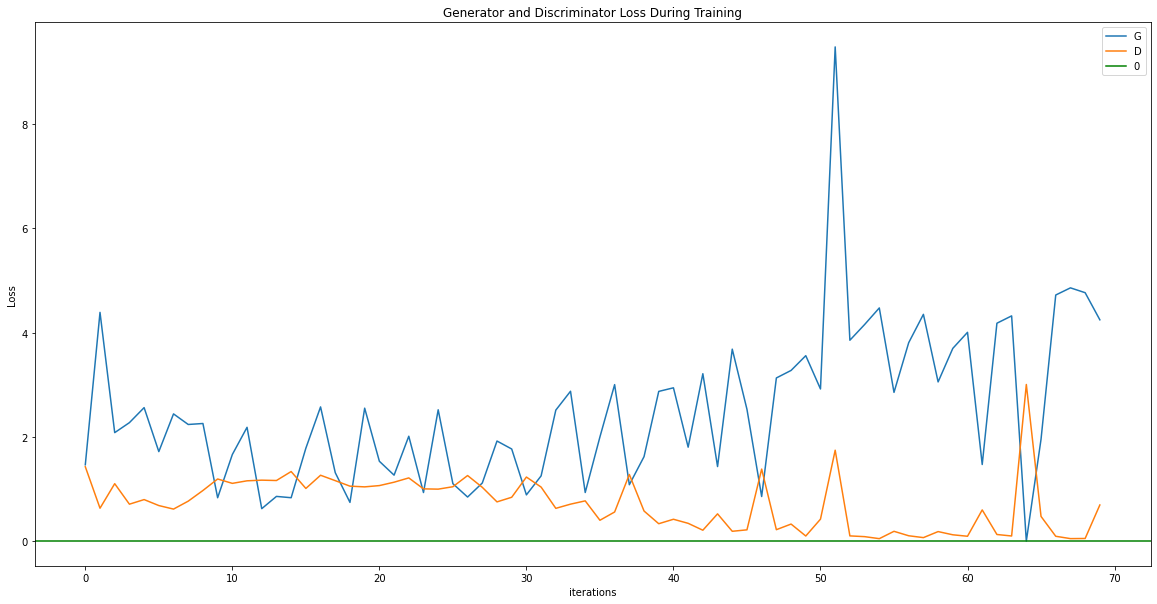

In [54]:
plt.figure(figsize=(20, 10))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses[::100], label="G")
plt.plot(D_losses[::100], label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.axhline(y=0, label="0", c='g') # asymptote
plt.legend()

# D(x) and D(G(z)) versus training iteration

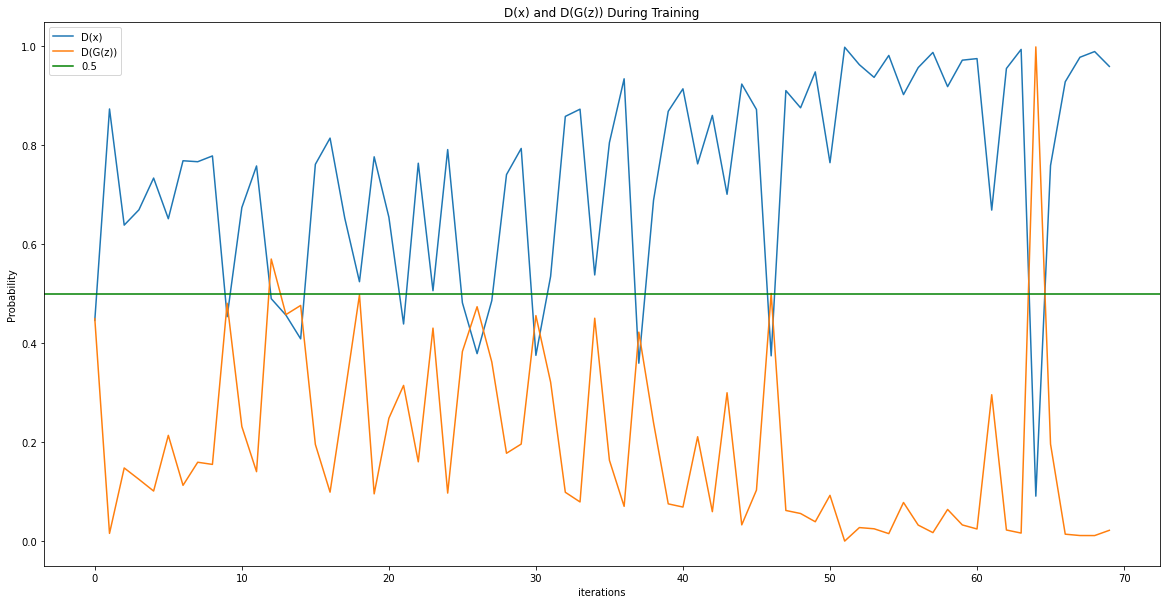

In [16]:
plt.figure(figsize=(20, 10))
plt.title("D(x) and D(G(z)) During Training")
plt.plot(D_x_list[::100], label="D(x)")
plt.plot(D_z_list[::100], label="D(G(z))")
plt.xlabel("iterations")
plt.ylabel("Probability")
plt.axhline(y=0.5, label="0.5", c='g') # asymptote
plt.legend()

# Visualization of G’s progression

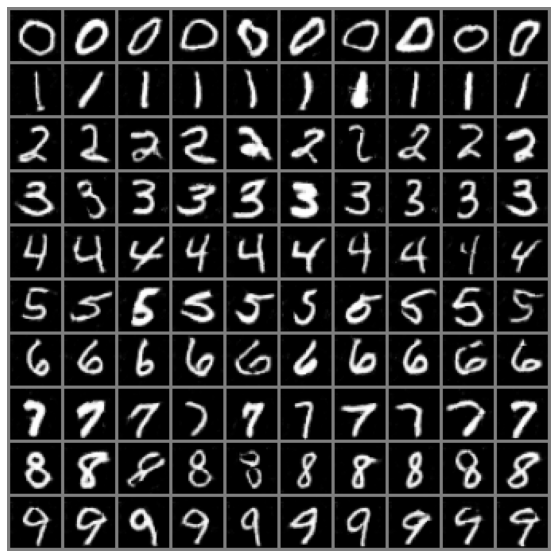

In [53]:
fig = plt.figure(figsize=(10, 10))
plt.axis("off")
ims = [[plt.imshow(item.permute(1, 2, 0), animated=True)] for item in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

# Real Images vs. Fake Images

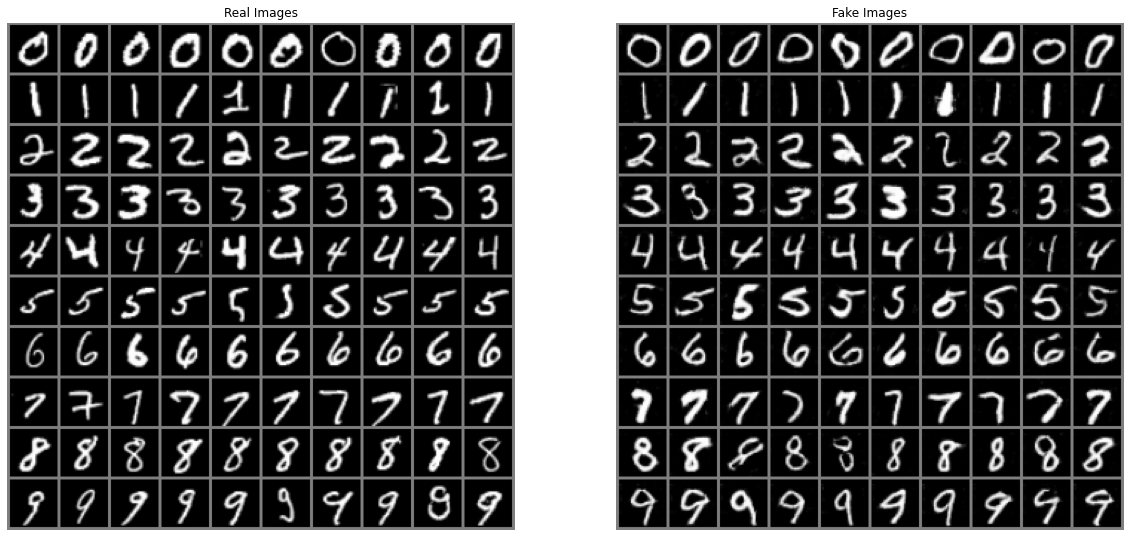

In [18]:
# Size of the Figure
plt.figure(figsize=(20,10))

# Plot the real images
plt.subplot(1,2,1)
plt.axis('off')
plt.title("Real Images")
imgs = utils.make_grid(imgs, nrow=10)
plt.imshow(imgs.permute(1, 2, 0)*0.5+0.5)

# Load the Best Generative Model
netG = Generator(0)
netG.load_state_dict(torch.load('model.pt', map_location=torch.device('cpu')))
netG.eval()

# Generate the Fake Images
with torch.no_grad():
    fake = netG(fixed_noise.cpu(), fixed_label.cpu())

# Plot the fake images
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
fake = utils.make_grid(fake, nrow=10)
plt.imshow(fake.permute(1, 2, 0)*0.5+0.5)

# Save the comparation result
plt.savefig('result.jpg', bbox_inches='tight')